In [1]:
%load_ext autoreload
%autoreload 2

## Shape analysis

The goal is to have a generalized algorithm that for all symmetrically equivalent cluster centers, find nearest atoms from trajectory, and transforms them back to the asymmetric unit. This helps the statistics for performing shape analysis and making plots.

As input:

1. crystal or material structure
    - contains cluster centers
    - includes symmetry operations
2. trajectory
    - typically P1
    - maybe a supercell of crystal structure
    - lattice can be triclinic (non-constrained in simulation)

Algorithm:

1. load clusters (pymatgen structure)
2. load trajectory (pymatgen trajectory)
3. reduce supercell of trajectory to match clusters
    - assert trajectory and cluster lattices match
4. for every unique cluster center, 
    5. for every symmetry operation
    - apply next symmetry operation to cluster center
    - find all trajectory points within X distance
    - copy and map points back to asymmetric unit (reverse symmetry op)
    - subtract cluster center coords
10. perform shape analysis
    - plots, fits, heat maps, msd, etc
   
See: https://github.com/GEMDAT-repos/GEMDAT/pull/166

In [2]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from gemdat import Trajectory
from gemdat.io import load_known_material

trajectory = Trajectory.from_vasprun(
    Path(
        '/home/stef/md-analysis-matlab-example-short/shape_analysis/vasprun.xml'
    ))

supercell = (2, 1, 1)

diff_trajectory = trajectory.filter('Li')

structure = load_known_material('argyrodite')

/home/stef/python/gemdat/.venv/lib64/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [3]:
diff_trajectory.get_lattice(0)

Lattice
    abc : 19.84771 9.923855 9.923855
 angles : 90.0 90.0 90.0
 volume : 1954.6600006747865
      A : 19.84771 0.0 0.0
      B : 0.0 9.923855 0.0
      C : 0.0 0.0 9.923855
    pbc : True True True

In [4]:
# collapse coords
positions = diff_trajectory.positions.reshape(-1, 3)
positions, positions.shape

(array([[0.16145033, 0.33547197, 0.02452775],
        [0.10760483, 0.71007687, 0.50529059],
        [0.37023313, 0.71662174, 0.00237432],
        ...,
        [0.5081269 , 0.69439527, 0.7062491 ],
        [0.91863445, 0.47414316, 0.64892594],
        [0.00493453, 0.24402231, 0.67557806]]),
 (240000, 3))

In [5]:
# collapse supercell
positions = np.mod(positions, 1 / np.array(supercell)) * np.array(supercell)
positions, positions.shape

(array([[0.32290066, 0.33547197, 0.02452775],
        [0.21520966, 0.71007687, 0.50529059],
        [0.74046626, 0.71662174, 0.00237432],
        ...,
        [0.0162538 , 0.69439527, 0.7062491 ],
        [0.8372689 , 0.47414316, 0.64892594],
        [0.00986906, 0.24402231, 0.67557806]]),
 (240000, 3))

In [6]:
from pymatgen import symmetry

sga = symmetry.analyzer.SpacegroupAnalyzer(structure)

symops = sga.get_space_group_operations()
symstruct = sga.get_symmetrized_structure()
lattice = symstruct.lattice
lattice

Lattice
    abc : 9.924 9.924 9.924
 angles : 90.0 90.0 90.0
 volume : 977.3728410239999
      A : 9.924 0.0 6.076697417369166e-16
      B : 1.5959009175390938e-15 9.924 6.076697417369166e-16
      C : 0.0 0.0 9.924
    pbc : True True True

## TODO

- [ ] Load sites from cif
- [ ] Loop over unique coords
- [ ] Store cluster per unique label
- [ ] seaborn plot
- [ ] density plot

In [7]:
thresh = 1.0  # Å

cluster = []

unq_coord = symstruct[0].frac_coords

print(unq_coord, '\n')

for op in symops:
    cluster_coord = op.operate(unq_coord)
    dists = lattice.get_all_distances(cluster_coord, positions)

    sel = dists < thresh
    close = positions[sel.flatten()]

    # digitize differences to move all close positions to
    # same sphere around cluster center
    offsets = np.digitize(close - cluster_coord, bins=[0.5, -0.4999999]) - 1

    close += offsets

    inversed = op.inverse.operate_multi(close)

    print(f'size: {len(inversed)}', end=', ')
    print('mean: {: .3f} {: .3f} {: .3f}'.format(*inversed.mean(axis=0)))

    cluster.append(inversed)

clusters = np.vstack(cluster) - unq_coord

[0.183 0.183 0.024] 

size: 4359, mean:  0.201  0.186  0.017
size: 4675, mean:  0.184  0.204  0.029
size: 5447, mean:  0.203  0.181  0.026
size: 5345, mean:  0.188  0.191  0.035
size: 4675, mean:  0.204  0.184  0.029
size: 4359, mean:  0.186  0.201  0.017
size: 5345, mean:  0.191  0.188  0.035
size: 5447, mean:  0.181  0.203  0.026
size: 3303, mean:  0.200  0.175  0.038
size: 3670, mean:  0.199  0.193  0.028
size: 4996, mean:  0.161  0.195  0.032
size: 4743, mean:  0.200  0.175  0.013
size: 3670, mean:  0.193  0.199  0.028
size: 3303, mean:  0.175  0.200  0.038
size: 4743, mean:  0.175  0.200  0.013
size: 4996, mean:  0.195  0.161  0.032
size: 3501, mean:  0.197  0.197  0.036
size: 1678, mean:  0.195  0.180  0.018
size: 3266, mean:  0.201  0.180  0.046
size: 1426, mean:  0.188  0.175  0.023
size: 1678, mean:  0.180  0.195  0.018
size: 3501, mean:  0.197  0.197  0.036
size: 1426, mean:  0.175  0.188  0.023
size: 3266, mean:  0.180  0.201  0.046
size: 3648, mean:  0.197  0.205  0.027
siz

48h  MSD (A^2) =  0.0038221813784490044  std =  0.002691167088034462


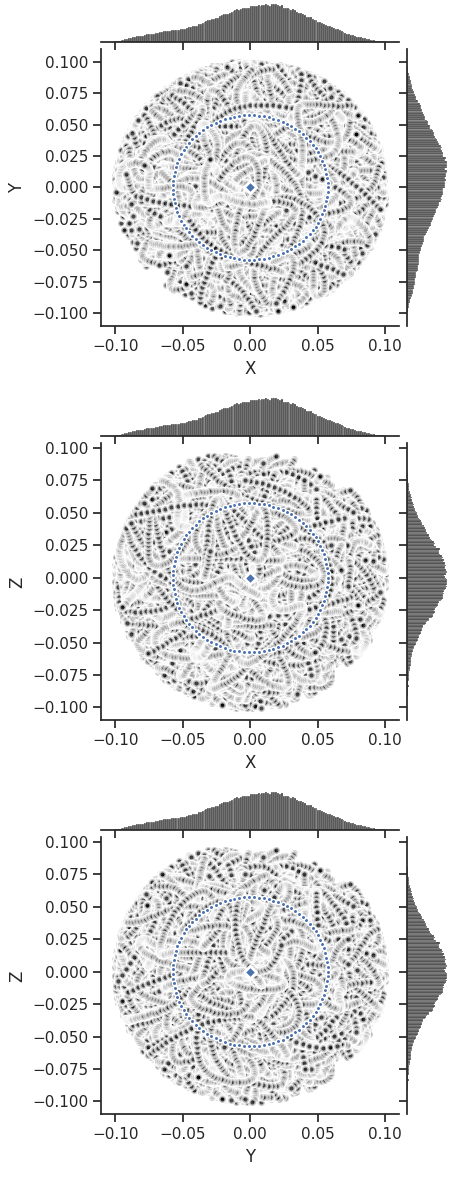

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            r + 1, r + 1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


color_palette = sns.color_palette()
sns.set_palette(color_palette)
sns.set_style("ticks")

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

for i in range(1):
    distances = np.sum(clusters**2, axis=1)**0.5
    print('48h', ' MSD (A^2) = ', np.mean(distances**2), ' std = ',
          np.std(distances**2))

    theta = np.linspace(0, 2 * np.pi, 100)  # 100 points around the circle
    x_circle = 0 + np.mean(distances) * np.cos(theta)
    y_circle = 0 + np.mean(distances) * np.sin(theta)

    g1 = sns.jointplot(x=clusters[:, 0],
                       y=clusters[:, 1],
                       marker='o',
                       s=25,
                       linewidth=2,
                       color='black',
                       alpha=0.7)
    sns.scatterplot(x=[0],
                    y=[0],
                    marker='D',
                    s=40,
                    linewidth=2,
                    color=color_palette[0],
                    ax=g1.ax_joint)
    sns.scatterplot(x=x_circle,
                    y=y_circle,
                    marker='o',
                    s=10,
                    linewidth=1,
                    color=color_palette[0],
                    ax=g1.ax_joint)
    g2 = sns.jointplot(x=clusters[:, 0],
                       y=clusters[:, 2],
                       marker='o',
                       s=25,
                       linewidth=2,
                       color='black',
                       alpha=0.7)
    sns.scatterplot(x=[0],
                    y=[0],
                    marker='D',
                    s=40,
                    linewidth=2,
                    color=color_palette[0],
                    ax=g2.ax_joint)
    sns.scatterplot(x=x_circle,
                    y=y_circle,
                    marker='o',
                    s=10,
                    linewidth=1,
                    color=color_palette[0],
                    ax=g2.ax_joint)
    g3 = sns.jointplot(x=clusters[:, 1],
                       y=clusters[:, 2],
                       marker='o',
                       s=25,
                       linewidth=2,
                       color='black',
                       alpha=0.7)
    sns.scatterplot(x=[0],
                    y=[0],
                    marker='D',
                    s=40,
                    linewidth=2,
                    color=color_palette[0],
                    ax=g3.ax_joint)
    sns.scatterplot(x=x_circle,
                    y=y_circle,
                    marker='o',
                    s=10,
                    linewidth=1,
                    color=color_palette[0],
                    ax=g3.ax_joint)

    mg0 = SeabornFig2Grid(g1, fig, gs[0, i])
    mg1 = SeabornFig2Grid(g2, fig, gs[1, i])
    mg2 = SeabornFig2Grid(g3, fig, gs[2, i])

    g1.ax_joint.set_xlabel('X')
    g1.ax_joint.set_ylabel('Y')
    g1.ax_joint.set_title('48h')
    g2.ax_joint.set_xlabel('X')
    g2.ax_joint.set_ylabel('Z')
    g3.ax_joint.set_xlabel('Y')
    g3.ax_joint.set_ylabel('Z')

gs.tight_layout(fig)
plt.show()